BIGRU TECHNOLOGY

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import spacy
import lime
import shap
import seaborn as sns
import string
from sklearn.preprocessing import LabelEncoder


In [2]:
data = pd.read_csv('C:/Users/sachu/Desktop/DB/dbitats.csv')

# Basic data inspection

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8984 entries, 0 to 8983
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           8984 non-null   int64  
 1   Resume_str   8984 non-null   object 
 2   Category     8984 non-null   object 
 3   Title        8984 non-null   object 
 4   description  8984 non-null   object 
 5   ATS_Score    8984 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 421.3+ KB
None


        text_length   word_count
count   8984.000000  8984.000000
mean    7194.406834   912.542409
std     2279.472075   312.008902
min     2538.000000   321.000000
25%     5652.000000   695.000000
50%     6887.000000   871.000000
75%     8450.000000  1041.000000
max    16142.000000  2044.000000


c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


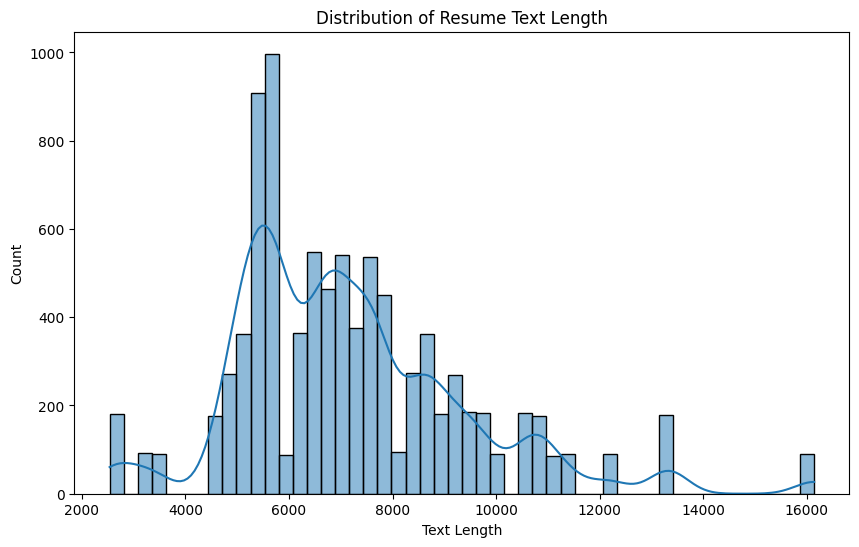

In [3]:
# Text Statistics
data['text_length'] = data['Resume_str'].apply(lambda x: len(str(x)))
data['word_count'] = data['Resume_str'].apply(lambda x: len(str(x).split()))
print(data[['text_length', 'word_count']].describe())

# Visualize text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=50, kde=True)
plt.title('Distribution of Resume Text Length')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()



# Handle missing values if any
data.dropna(inplace=True)

# Encode categorical variables like 'Category'
encoder = LabelEncoder()
data['Category'] = encoder.fit_transform(data['Category'])

In [4]:
import spacy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load the English model
nlp = spacy.load("en_core_web_sm")


# Abbreviations dictionary for job market
abbreviations = {
    "mgr": "manager",
    "sr": "senior",
    "jr": "junior",
    "asst": "assistant",
    "assoc": "associate",
    "dept": "department",
    "exp": "experience",
    "hr": "human resources",
    "acct": "account",
    "acctg": "accounting",
    "fin": "finance",
    "eng": "engineer",
    "engg": "engineering",
    "it": "information technology",
    "qa": "quality assurance",
    "dev": "development",
    "devops": "development operations",
    "proj": "project",
    "mktg": "marketing",
    "biz": "business",
    "comm": "communication",
    "adm": "administration",
    "sec": "secretary",
    "exec": "executive",
    "corp": "corporation",
    "intl": "international",
    "rep": "representative",
    "mfg": "manufacturing",
    "prod": "production",
    "purch": "purchasing",
    "sales": "sales",
    "cust": "customer",
    "svc": "service",
    "tech": "technical",
    "sup": "supervisor",
    "supv": "supervision",
    "log": "logistics",
    "inv": "inventory",
    "sch": "schedule",
    "edu": "education",
    "lang": "language",
    "pr": "public relations",
    "hrd": "human resources development",
    "cfo": "chief financial officer",
    "ceo": "chief executive officer",
    "coo": "chief operating officer",
    "cmo": "chief marketing officer",
    "cto": "chief technology officer",
    "cio": "chief information officer",
    "pmo": "project management office",
    "pmp": "project management professional",
    "ba": "business analyst",
    "bpm": "business process management",
    "ui": "user interface",
    "ux": "user experience",
    "svp": "senior vice president",
    "vp": "vice president",
    "gm": "general manager",
    "doe": "depends on experience",
    "r&d": "research and development",
    "seo": "search engine optimization",
    "sem": "search engine marketing",
    "smm": "social media marketing",
    "b2b": "business to business",
    "b2c": "business to consumer",
    "kpi": "key performance indicator",
    "roi": "return on investment",
    "saas": "software as a service",
    "paas": "platform as a service",
    "iaas": "infrastructure as a service",
    "crm": "customer relationship management",
    "erp": "enterprise resource planning",
    "sd": "software development",
    "pm": "project manager",
    "pa": "personal assistant",
    "exec": "executive",
    "fin": "finance",
    "hrm": "human resources management",
    "it": "information technology",
    "pr": "public relations",
    "qa": "quality assurance",
    "r&d": "research and development",
    "scm": "supply chain management",
    "seo": "search engine optimization",
    "smm": "social media marketing",
    "ux": "user experience",
    "ui": "user interface",
    "bi": "business intelligence",
    "dev": "development",
    "ops": "operations"
}


def expand_abbreviations(text, abbreviations):
    for abbr, expanded in abbreviations.items():
        text = re.sub(r'\b{}\b'.format(abbr), expanded, text)
    return text

def clean_and_preprocess(text):
    text = expand_abbreviations(text, abbreviations)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return ' '.join(tokens)

def extract_nouns(text):
    doc = nlp(text)
    nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
    return nouns

# Apply cleaning and preprocessing
data['processed_resume'] = data['Resume_str'].apply(clean_and_preprocess)
data['processed_description'] = data['description'].apply(clean_and_preprocess)



In [5]:
max_sequence_length = 1500

# Extract nouns separately for resumes and job descriptions
data['resume_nouns'] = data['processed_resume'].apply(extract_nouns)
data['description_nouns'] = data['processed_description'].apply(extract_nouns)

# Find common nouns between resume and job description
data['common_nouns'] = data.apply(lambda row: list(set(row['resume_nouns']).intersection(set(row['description_nouns']))), axis=1)

# Convert list of common nouns to string
data['common_nouns_str'] = data['common_nouns'].apply(lambda x: ' '.join(x))

# Tokenizer and sequences for common nouns
common_nouns_tokenizer = Tokenizer()
common_nouns_tokenizer.fit_on_texts(data['common_nouns_str'])

common_nouns_sequences = common_nouns_tokenizer.texts_to_sequences(data['common_nouns_str'])
max_common_nouns_length = 10  # Adjust based on your data
common_nouns_data = pad_sequences(common_nouns_sequences, maxlen=max_common_nouns_length)

# Prepare other data
resume_tokenizer = Tokenizer()
resume_tokenizer.fit_on_texts(data['processed_resume'])
resume_sequences = resume_tokenizer.texts_to_sequences(data['processed_resume'])
resume_data_padded = pad_sequences(resume_sequences, maxlen=max_sequence_length)

description_tokenizer = Tokenizer()
description_tokenizer.fit_on_texts(data['processed_description'])
description_sequences = description_tokenizer.texts_to_sequences(data['processed_description'])
description_data_padded = pad_sequences(description_sequences, maxlen=max_sequence_length)

# Target variable
y = data['ATS_Score'].values

In [6]:
import pickle

# Define a dictionary to store all the tokenizers
tokenizers = {
    'resume_tokenizer': resume_tokenizer,
    'description_tokenizer': description_tokenizer,
    'common_nouns_tokenizer': common_nouns_tokenizer
}
save_path = r'C:\Users\sachu\Desktop\DB\Pickel\tokenizersit.pkl'

# Save the dictionary of tokenizers to a pickle file
with open(save_path, 'wb') as f:
    pickle.dump(tokenizers, f)

print("Tokenizers saved successfully.")

Tokenizers saved successfully.


In [7]:
data.to_csv(r'C:\Users\sachu\Desktop\DB\PreProcessDB\dbitpreprocess.csv', index=False)

In [8]:
X_train_resume, X_test_resume, X_train_description, X_test_description, X_train_common, X_test_common, y_train, y_test = train_test_split(
    resume_data_padded, description_data_padded, common_nouns_data, y, test_size=0.2, random_state=42
)

# Split training data further into training and validation sets
X_train_resume, X_val_resume, X_train_description, X_val_description, X_train_common, X_val_common, y_train, y_val = train_test_split(
    X_train_resume, X_train_description, X_train_common, y_train, test_size=0.2, random_state=42
)

# Check shapes after splitting
print(f"X_train_resume shape: {X_train_resume.shape}")
print(f"X_train_description shape: {X_train_description.shape}")
print(f"X_train_common shape: {X_train_common.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_val_resume shape: {X_val_resume.shape}")
print(f"X_val_description shape: {X_val_description.shape}")
print(f"X_val_common shape: {X_val_common.shape}")
print(f"y_val shape: {y_val.shape}")


X_train_resume shape: (5749, 1500)
X_train_description shape: (5749, 1500)
X_train_common shape: (5749, 10)
y_train shape: (5749,)
X_val_resume shape: (1438, 1500)
X_val_description shape: (1438, 1500)
X_val_common shape: (1438, 10)
y_val shape: (1438,)


In [9]:
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout, concatenate, SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import Input

# Model Inputs
resume_input = Input(shape=(max_sequence_length,), name='resume_input')
description_input = Input(shape=(max_sequence_length,), name='description_input')
common_input = Input(shape=(max_common_nouns_length,), name='common_input')

# Embedding Layer for resume
embedding_dim = 100  # Adjust based on your embedding size
resume_embedding_layer = Embedding(input_dim=len(resume_tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length)(resume_input)
description_embedding_layer = Embedding(input_dim=len(description_tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length)(description_input)

# Apply Spatial Dropout
resume_embedded_dropout = SpatialDropout1D(0.2)(resume_embedding_layer)
description_embedded_dropout = SpatialDropout1D(0.2)(description_embedding_layer)

# Bidirectional GRU Layers
resume_gru = Bidirectional(GRU(128, return_sequences=True, dropout=0.3))(resume_embedded_dropout)
description_gru = Bidirectional(GRU(128, return_sequences=True, dropout=0.3))(description_embedded_dropout)

# Global Average Pooling
resume_gru_pool = GlobalAveragePooling1D()(resume_gru)
description_gru_pool = GlobalAveragePooling1D()(description_gru)

# Dense Layers for Common Input
common_dense = Dense(32, activation='relu')(common_input)

# Combine GRU outputs with common dense layer
combined = concatenate([resume_gru_pool, description_gru_pool, common_dense])

# Additional Dense Layers with Regularization
x = Dense(64, activation='relu')(combined)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# Output Layer
output = Dense(1, activation='linear')(x)

# Model definition
model = Model(inputs=[resume_input, description_input, common_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model Summary
model.summary()

c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ resume_input        │ (None, 1500)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ description_input   │ (None, 1500)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1500, 100) │    545,500 │ resume_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1500, 100) │    440,400 │ description_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 1500, 100) │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 1500, 100) │          0 │ embedding_1[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 1500, 256) │    176,640 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 1500, 256) │    176,640 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ common_input        │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ bidirectional[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ bidirectional_1[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        352 │ common_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 544)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     34,880 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 1,376,525 (5.25 MB)

 Trainable params: 1,376,525 (5.25 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Training the modified model
history = model.fit(
    [X_train_resume, X_train_description, X_train_common], y_train,
    epochs=5,  # Example value, can be adjusted
    batch_size=64,  # Example value, can be adjusted
    validation_data=([X_val_resume, X_val_description, X_val_common], y_val),
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([X_test_resume, X_test_description, X_test_common], y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4807s 53s/step - loss: 1476.9681 - mae: 31.3312 - val_loss: 232.6540 - val_mae: 12.5642 - learning_rate: 0.0010
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 5093s 57s/step - loss: 433.3509 - mae: 16.7579 - val_loss: 181.7176 - val_mae: 10.8279 - learning_rate: 0.0010
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 6982s 78s/step - loss: 315.6433 - mae: 14.3691 - val_loss: 126.0356 - val_mae: 8.9860 - learning_rate: 0.0010
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3971s 44s/step - loss: 287.9932 - mae: 13.5958 - val_loss: 193.5180 - val_mae: 11.6940 - learning_rate: 0.0010
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3513s 39s/step - loss: 260.9638 - mae: 12.9396 - val_loss: 102.7569 - val_mae: 8.1718 - learning_rate: 0.0010
57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 513ms/step - loss: 103.8475 - mae: 8.3259
Test Loss: 105.48522186279297
Test MAE: 8.32217788696289


In [11]:
save_path = r'C:\Users\sachu\Desktop\DB\ModelSave\bigit2.keras'

# Save the model to the specified path
model.save(save_path)

print(f"Model saved successfully to {save_path}.")

Model saved successfully to C:\Users\sachu\Desktop\DB\ModelSave\bigit2.keras.


In [12]:
y_pred = model.predict([X_test_resume, X_test_description, X_test_common])

57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 471ms/step


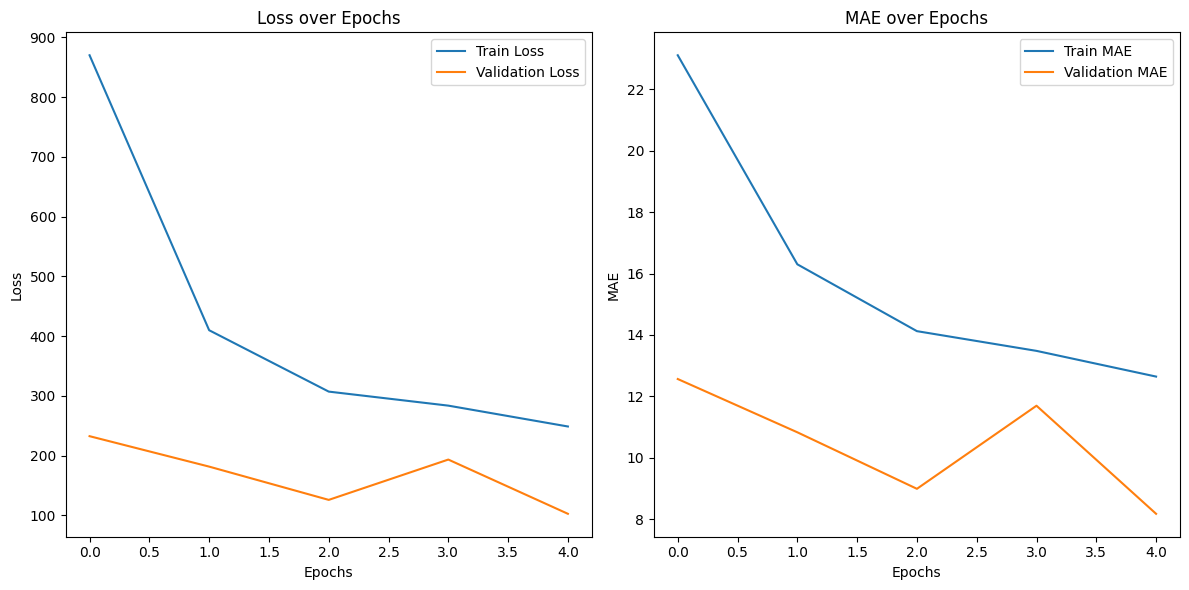

In [13]:
# Plot training history
import matplotlib.pyplot as plt


# Get history data from the History object
history_dict = history.history

# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'], label='Train MAE')
plt.plot(history_dict['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()
